In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from scipy.integrate import solve_ivp

plt.ion()
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
## ASSUMPTIONS
# Assumed each cell has equal carbon content.
# Assumed organic carbon content is equal throughout cell lifespan, including death.
# Assumed cells contain no inorganic carbon upon death.
# Assumed constant death fraction.
# Assumed each live cell divides at same rate.
# Assumed constant carbon fixing factor.
# Assumed organic carbon content arround the brine is equal throughout brine lifespan.
# Assumed diffusion has no effect within the brine.
# Assumed no external disturbance to the brine.
# Assumed selected organism represents entire brine microbial community kinetics.
# Assumed organic carbon to be the only limiting element.
## -> Therefore, assumed the carbon source is also providing nitrogen.
# Assumed dry mass of cell is equal to carbon content per cell.
# Assumed that mu/Yg (carbon consumed for processes other than maintenance) is converted to inorganic carbon.
######
# Assumed brine is a prolte spheroid.
# Assumes proportional expansion of the brine volume in every direction.
# Assumes brine volume expansion cycle occurs once a year, in one peak. 


## CONSTANTS
# conversions
one_kilo_in_femto = 10 ** 18
one_microgram_in_femto = 10 ** 9
one_m2_in_cm2 = 10000
one_gram_in_femto = 10 ** 15
one_gram_in_microgram = 10 ** 6


## BRINE VOLUME PARAMATERS
# Prolate spheroid dimensions
a = 2.185099  # cm - width 
b = 4  # cm - length
brine_volume = 4/3 * 3.14159 * (a/2) ** 2 * (b/2)  # Volume of prolate spheroid: V = 4/3 * pi * (a/2) ** 2 * (b/2)


## MODEL PARAMATERS
# Organic carbon around brine
utgiagvik_nutrients_per_cm2_for_100cm = 83.4/one_m2_in_cm2 * one_kilo_in_femto  # fg/cm2 - Initial C available per cm2 over 100cm depth if SOCC100.
utgiagvik_nutrients_depth = 100  # cm - The NCSCD gives cm2 numbers over a total depth.
# Organic carbon input
organic_carbon_from_input = 10 ** 8 * 70  # fg/ml - Organic arbon input per day.
# Inorganic carbon input
inorganic_carbon_from_input = 0  # fg/ml - Inorganic carbon input per day.

# Community paramaters
natural_death_fraction = 0.001  # % - Fraction of cells present that will die at any time t.

# Heterotroph organism paramaters
ks = 882000000  # fg C - The organic carbon concentration at which u = 1/2 u0.
carbon_content_per_cell = 140  # fg/cell -  Amount of organic carbon per cell.
mu_max = 0.06  # day^-1 - Max growth rate.
growth_penalty = 0.5  # % - Penalty to reduce u_max by. 0 is normal growth.
base_maintenance_per_cell = 0.0006/(0.00069*0.4)  # fg carbon/fg dry mass x day - Constant maintenance energy coefficient.
m_prime = 0  # fg glucose/fg dry mass - Growth rate dependent maintenance coefficient, known as m_prime in pirt (1982).
maximum_growth_yield = 75/72.07  # fg dry mass/fg carbon - Maximum growth yield.

# Inorganic carbon fixing paramaters
inorganic_carbon_fixing_factor = 0  # % - The percentage of inorganic carbon present fixed.

# System paramaters
maximum_cell_count = 10 ** 9  # cells/ml - The maximum bacterial abundance per ml after which mu = 0.
duration = 11000 * 365.25  # days - Duration of the system.

# Initial conditions
initial_carbon_content = utgiagvik_nutrients_per_cm2_for_100cm / utgiagvik_nutrients_depth  # fg/ml - Initial amount of organic carbon in the system per ml/
initial_inorganic_carbon_content = 0  # fg/ml - Initial amount of inorganic carbon in the system per ml.
initial_cell_count = 10 ** 5  # cells/ml - Initial number of cells in the system per ml.

In [3]:
# PARAMATER CHECKS
assert ks >= 0
assert carbon_content_per_cell >= 0
assert 1 >= growth_penalty >= 0
assert 1 >= inorganic_carbon_fixing_factor >= 0
assert maximum_cell_count >= 0
assert duration >= 0
assert initial_carbon_content >= 0
assert initial_inorganic_carbon_content >= 0
assert initial_cell_count >= 0

In [4]:
# Set up initial condition vector
y0 = [initial_carbon_content, initial_inorganic_carbon_content, initial_cell_count]
t_span = (0, duration)  # time grid

In [5]:
def model(t, y):
        
    organic_carbon_content = y[0]
    inorganic_carbon_content = y[1]
    cell_count = y[2]
    
    ## CELL COUNT 
    # Growth
    penalized_mu_max = mu_max * (1 - growth_penalty)
    growth = floor(penalized_mu_max * (organic_carbon_content / (ks + organic_carbon_content)) * cell_count * t)
    
    # Natural Death
    natural_deaths = ceil(natural_death_fraction * cell_count)
    
    # Specific growth rate
    next_cell_count = cell_count + growth - natural_deaths
    specific_growth_rate = 0 if t == 0 else max((np.log(next_cell_count) - np.log(cell_count))/t, 0)
        
    # Handle maximum cell count
    if next_cell_count >= maximum_cell_count:
        specific_growth_rate = 0
    
    # Organic carbon requirement
    maintenance_per_cell = base_maintenance_per_cell + m_prime*(1 - ((1/mu_max)*specific_growth_rate))
    consumption_per_cell = specific_growth_rate/maximum_growth_yield
    
    required_organic_carbon_per_cell = (maintenance_per_cell + consumption_per_cell) * t * (cell_count * carbon_content_per_cell)
    required_organic_carbon = required_organic_carbon_per_cell * cell_count
    
    # Starvation
    starvation_deaths = 0 
    if organic_carbon_content < required_organic_carbon: 
        starvation_deaths = ceil((required_organic_carbon - organic_carbon_content) / required_organic_carbon_per_cell)
    
    # Deaths
    deaths = starvation_deaths + natural_deaths
    
    # Net cell count change
    dndt = growth - deaths
    
    # Maximum cell count
    if next_cell_count >= maximum_cell_count:
        dndt = maximum_cell_count - cell_count   
    
    ## INORGANIC CARBON
    # Inorganic carbon inputs
    respired_carbon = consumption_per_cell * (cell_count - starvation_deaths)
    total_inorganic_carbon_inputs = inorganic_carbon_from_input + respired_carbon
    
    # Inorganic carbon outputs
    fixed_inorganic_carbon = inorganic_carbon_fixing_factor*inorganic_carbon_content
    total_inorganic_carbon_outputs = fixed_inorganic_carbon
    
    # Net inorganic carbon change
    didt = total_inorganic_carbon_inputs - total_inorganic_carbon_outputs
    
    
    ## ORGANIC CARBON
    # Organic carbon inputs
    organic_carbon_from_deaths = deaths * carbon_content_per_cell
    total_organic_carbon_inputs = organic_carbon_from_input + organic_carbon_from_deaths + fixed_inorganic_carbon
      
    # Organic carbon outputs
    consumed_organic_carbon_from_population = required_organic_carbon_per_cell * (cell_count - starvation_deaths)
    consumed_organic_carbon_from_growth = dndt * carbon_content_per_cell
    total_organic_carbon_outputs = consumed_organic_carbon_from_population + consumed_organic_carbon_from_growth
      
    # Net organic carbon change
    dsdt = total_organic_carbon_inputs - total_organic_carbon_outputs
    
    ## Concentrations can't drop below 0.
    if organic_carbon_content + dsdt < 0:
        dsdt = -organic_carbon_content

    if inorganic_carbon_content + didt < 0:
        didt = -inorganic_carbon_content
        
    return [dsdt, didt, dndt]
    

In [6]:
# solve the ODEs
soln = solve_ivp(fun=model, y0=y0, t_span=t_span)
N = soln.y[0]
IC = soln.y[1]
B = soln.y[2]
t = soln.t

<IPython.core.display.Javascript object>


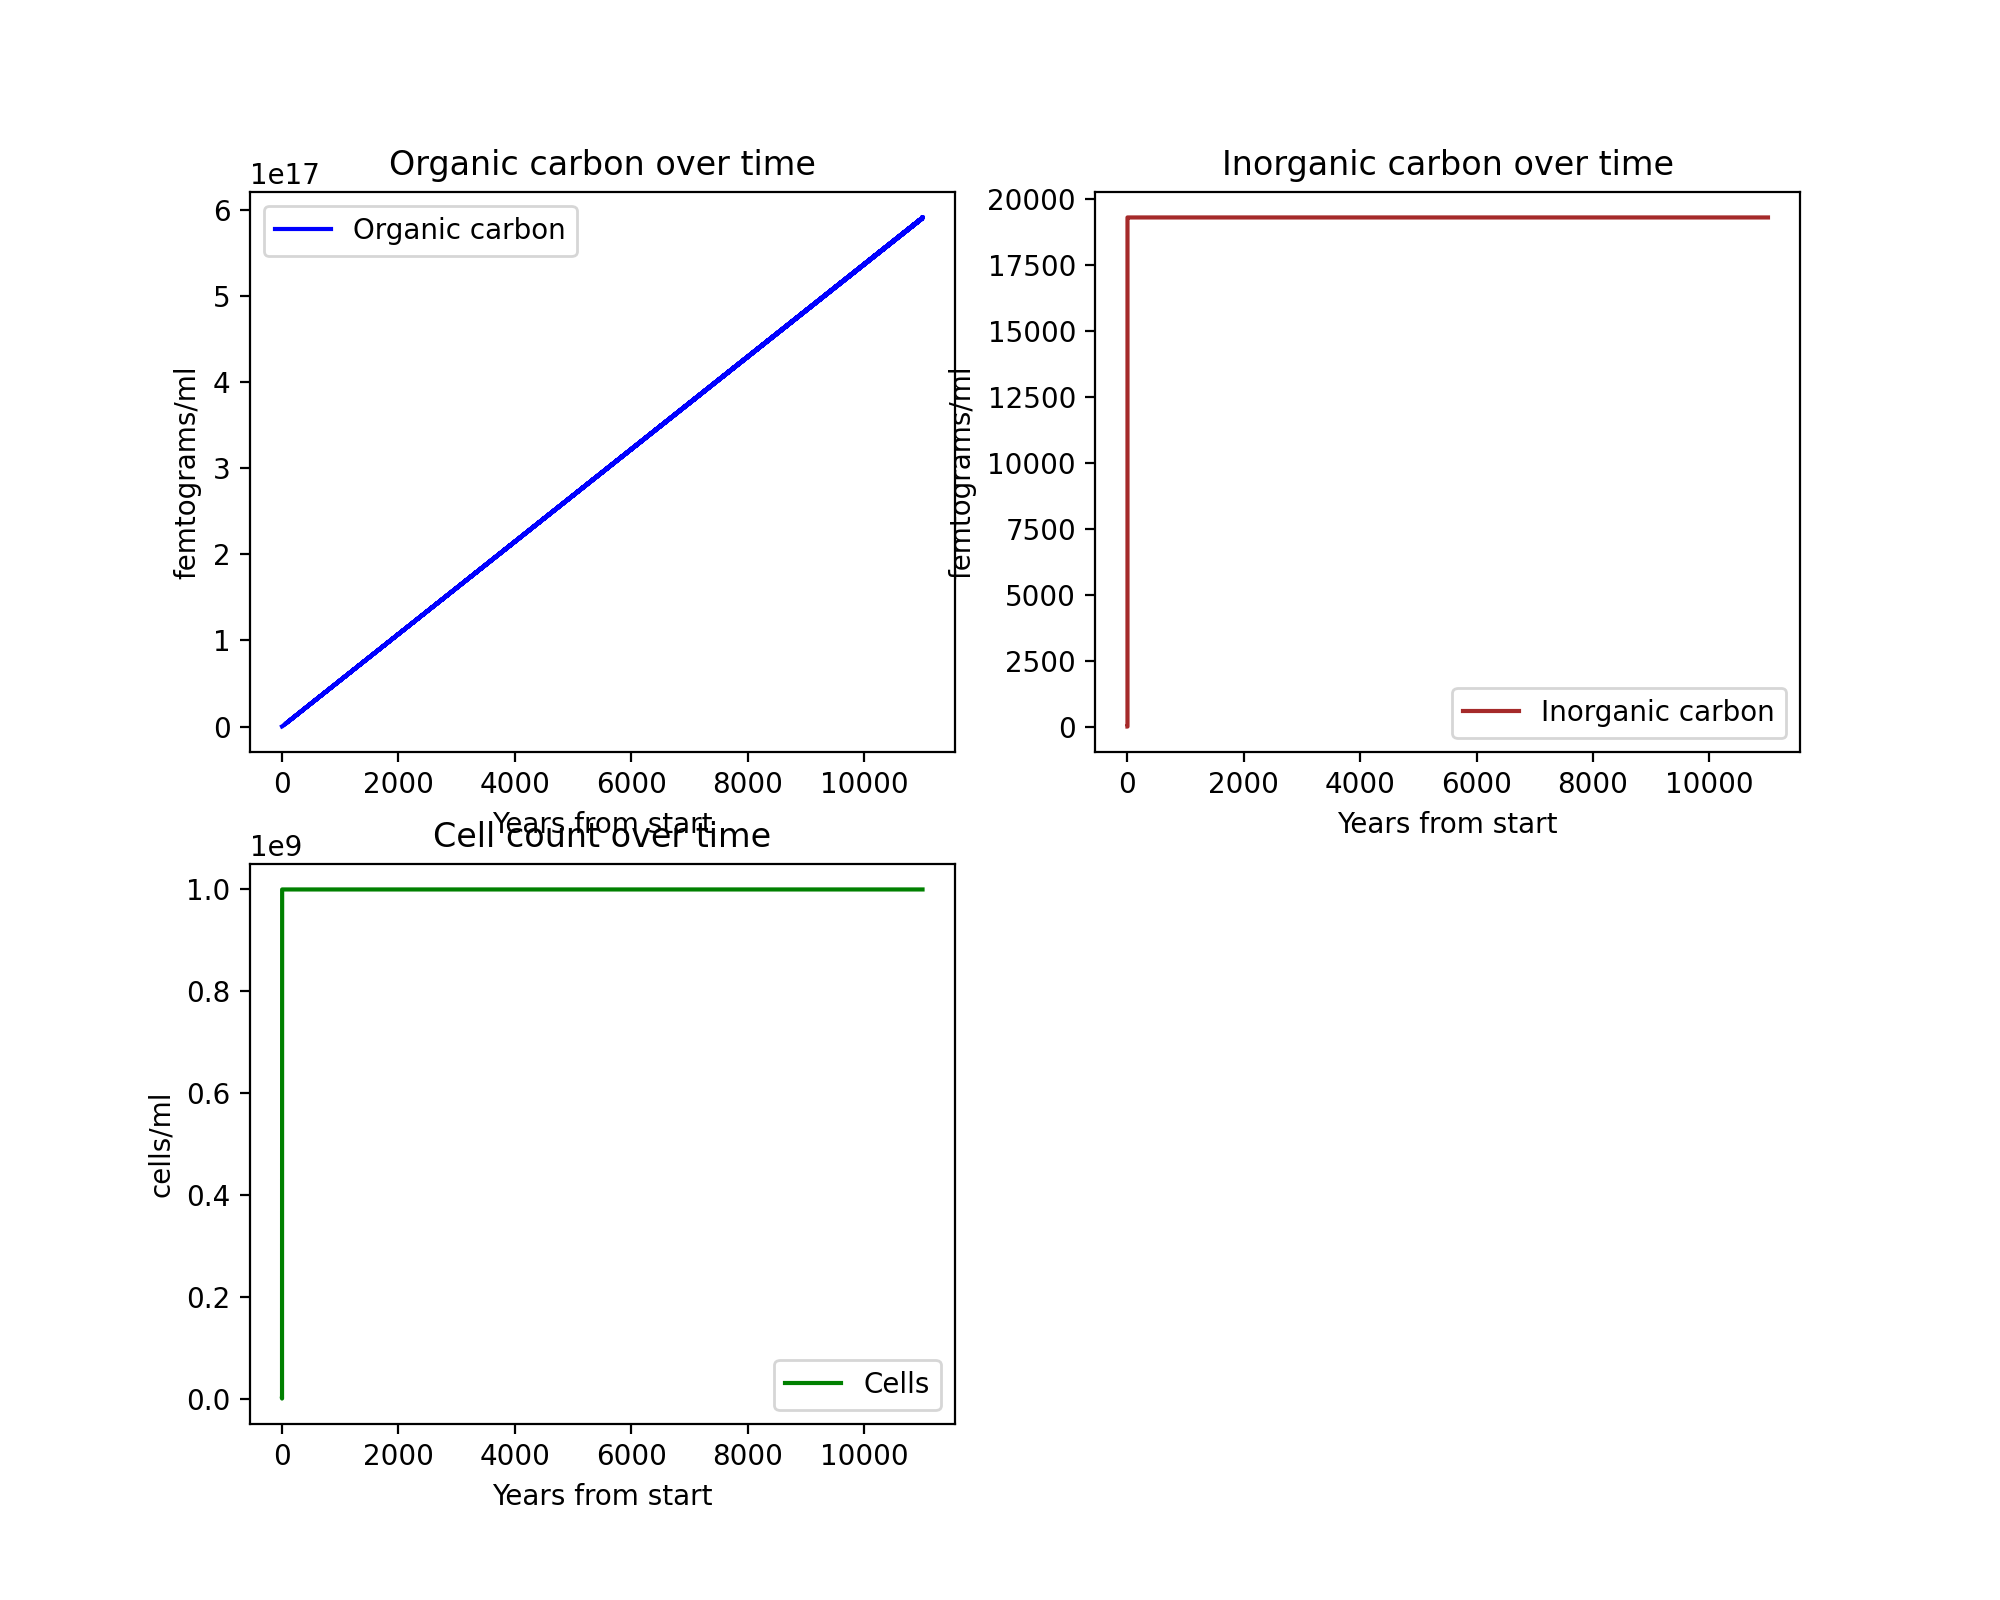

In [7]:
# Organic carbon plot
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(t / 365, N, label='Organic carbon', color="blue")
plt.xlabel('Years from start')
plt.ylabel('femtograms/ml')
plt.title('Organic carbon over time')
plt.legend(loc=0)

# Inorganic carbon plot
plt.subplot(2, 2, 2)
plt.plot(t / 365, IC, label='Inorganic carbon', color="brown")
plt.xlabel('Years from start')
plt.ylabel('femtograms/ml')
plt.title('Inorganic carbon over time')
plt.legend(loc=0)

# Cell count plot
plt.subplot(2, 2, 3)
plt.plot(t / 365, B, label='Cells', color="green")
plt.xlabel('Years from start')
plt.ylabel('cells/ml')
plt.title('Cell count over time')
plt.legend(loc=0)

# Add variables onto the plot
# runtime_vars1 = ""
# plt.figtext(0.1, 0.3, runtime_vars1, wrap=True, horizontalalignment='left', fontsize=12)
# plt.figtext(0.55, 0.3, runtime_vars2, wrap=True, horizontalalignment='left', fontsize=12)
# plt.figtext(0.1, 0.15, runtime_vars3, wrap=True, horizontalalignment='left', fontsize=12)
# plt.figtext(0.55, 0.15, runtime_vars4, wrap=True, horizontalalignment='left', fontsize=12)

# plt.subplots_adjust(bottom=0.5)
# plt.savefig("plot.pdf", format="pdf")
plt.show()

In [8]:
# Lower and upper bounds for how much migration we need. From Go excel file.
carbon_density_lower = 51.23/(10**6)   # g/ml - Carbon surrounding the brine (lower bound)
carbon_density_upper = 1286.81/(10**6)   # g/ml - Carbon surrounding the brine (upper bound)

# Calculate system organic carbon requirements
total_carbon_required = (IC[-1] - initial_carbon_content)/one_gram_in_femto * brine_volume  # grams 
total_carbon_required_per_year = total_carbon_required/(duration/365.25)  # (grams) /year

# Calculate volume needed to expand
volume_needed_lower = total_carbon_required_per_year/carbon_density_lower  # The volume that must be covered to get the required amount of C
volume_needed_upper = total_carbon_required_per_year/carbon_density_upper  # The volume that must be covered to get the required amount of C

# Expansion ratio of volime
ratio_lower = volume_needed_lower/brine_volume
ratio_upper = volume_needed_upper/brine_volume

# Expansion ratio of area
ratio_area_lower = (1 + volume_needed_lower/brine_volume) ** (2/3) 
ratio_area_upper = (1 + volume_needed_upper/brine_volume) ** (2/3)

# Expansion ratio linearly
ratio_dimensions_lower = (1 + volume_needed_lower/brine_volume) ** (1/3) 
ratio_dimensions_upper = (1 + volume_needed_upper/brine_volume) ** (1/3)

a_low = a*ratio_dimensions_lower
b_low = b*ratio_dimensions_lower

a_high = a*ratio_dimensions_upper
b_high = b*ratio_dimensions_upper 

print("Total carbon required over timespan is: " + "{:.3f}".format(total_carbon_required) + "g")
print("Total carbon required on average per year is: " + "{:.3f}".format(total_carbon_required_per_year) + "g")

print("Lower bound for % expansion of volume based on brine volume per year is: " + "{:.0f}".format(ratio_lower*100) +"%")
print("Upper bound for % expansion of volume based on brine volume per year is: " + "{:.0f}".format(ratio_upper*100) +"%")

print("Lower bound for % expansion of area based on brine volume per year is: " + "{:.0f}".format((ratio_area_lower-1)*100) +"%")
print("Upper bound for % expansion of area based on brine volume per year is: " + "{:.0f}".format((ratio_area_upper-1)*100) +"%")

print("Lower bound of carbon, brine will expand by (a, b) cm per year: ("+ "{:.2f}".format(a_low) + ", " + "{:.2f}".format(b_low) +") = " + "{:.0f}".format((ratio_dimensions_lower-1)*100) +"%")
print("Upper bound of carbon, brine will expand by (a, b) cm per year: ("+ "{:.2f}".format(a_high) + ", " + "{:.2f}".format(b_high) +") = " + "{:.0f}".format((ratio_dimensions_upper-1)*100) +"%")

Total carbon required over timespan is: -0.834g
Total carbon required on average per year is: -0.000g
Lower bound for % expansion of volume based on brine volume per year is: -15%
Upper bound for % expansion of volume based on brine volume per year is: -1%
Lower bound for % expansion of area based on brine volume per year is: -10%
Upper bound for % expansion of area based on brine volume per year is: -0%
Lower bound of carbon, brine will expand by (a, b) cm per year: (2.07, 3.79) = -5%
Upper bound of carbon, brine will expand by (a, b) cm per year: (2.18, 3.99) = -0%
